In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src

In [2]:
# ASCADf | ASCADv
ds = 'ASCADv'
snr = np.load(f'/workspace/results/simulation/{ds}_SNR.npz')

In [3]:
save_path = f'/workspace/results/ascad/MLP_{ds}'
with hydra.initialize(config_path="../../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=MLP_ASCAD",
            "model.train_params.steps=50000",
            f"dataset@train={ds}_profiling",
            f"dataset@test={ds}_attack",
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            "trace_transforms=void",
            f"save_path={save_path}",
            "n_attack_traces=2000",
            ]
        )

In [4]:
device = hydra.utils.instantiate(cfg.device)
cpu = torch.device('cpu')

In [5]:
def calc_act_scale(model, KANds):
    x = KANds['test_input'][:10000]
    x.requires_grad = True
    model.zero_grad()
    p = model(x)
    loss = torch.nn.BCEWithLogitsLoss()(KANds['test_label'][:10000], p)
    loss.backward()
    grad = x.grad.detach().to(cpu).numpy()
    return np.abs(np.mean(grad, axis=0))


def plot_scale(model, KANds, idx_mask=None):
    x = np.arange(0, KANds['test_input'].shape[1], 1)
    print(x.shape)
    y = np.zeros(x.shape)
    if idx_mask is None:
        idx_mask = np.ones(x.shape, dtype=bool)
    y[idx_mask] = calc_act_scale(model, KANds)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(211)
    for k in list(snr.keys())[1:]:
        ax.plot(snr[k], label=k)
    ax.set_xlabel('Time samples')
    ax.set_ylabel('SNR value')
    plt.legend(loc='upper left')

    ax2 = fig.add_subplot(212)
    ax2.set_xlabel('Time samples')
    ax2.set_ylabel('Sensitivity')
    ax2.plot(x, y, label='Sensitivity')
    plt.legend(loc='upper left')
    plt.tight_layout()
    return fig

In [6]:
profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
test_dataset = hydra.utils.instantiate(cfg.test.dataset)

train_dataloader = torch.utils.data.DataLoader(
    profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)
KANds = src.utils.to_KAN_dataset(
    train_dataloader, test_dataloader,
    device=device)

In [7]:
model = hydra.utils.instantiate(cfg.model.model)
model.load_state_dict(torch.load(
    Path(cfg.save_path, cfg.model_name+'.pt')))
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(1400,)


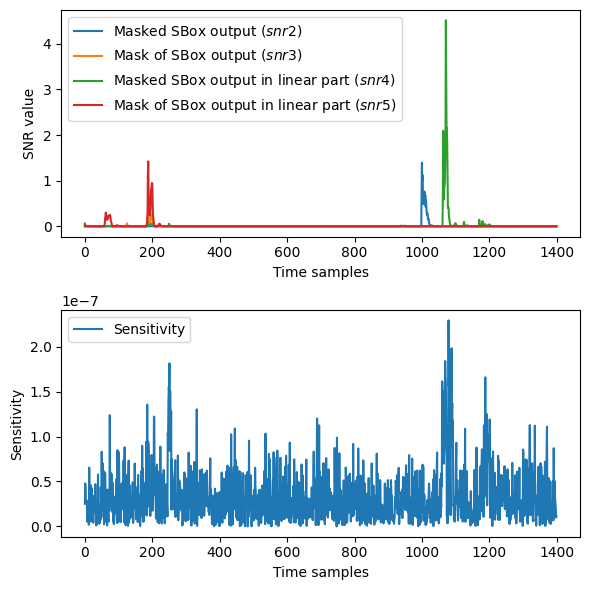

In [8]:
p = Path('/workspace/results/ascad/')
p.mkdir(exist_ok=True, parents=True)
fig = plot_scale(model, KANds)
fig.savefig(Path(p, f'sensitivity_MLP_{ds}.png'), dpi=300, bbox_inches=0)

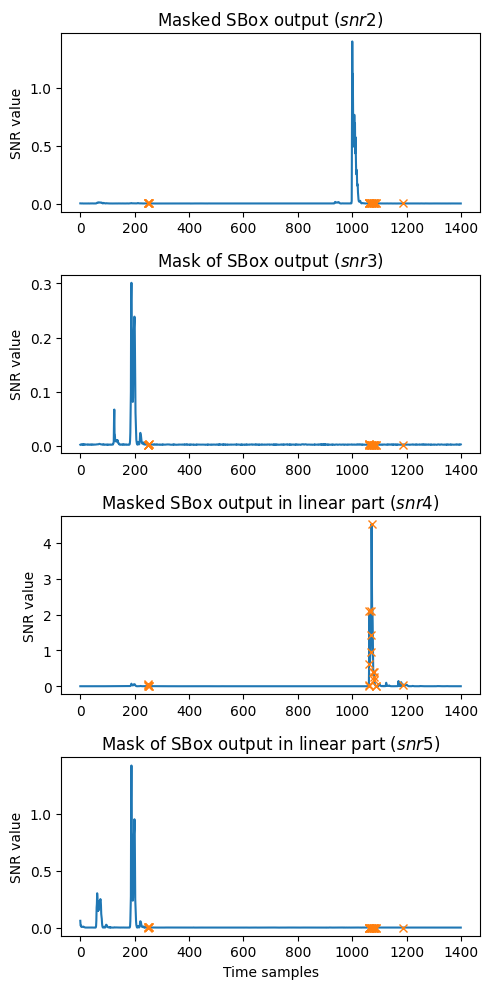

In [9]:
scale_idx = calc_act_scale(model, KANds).argsort()[::-1]

fig = plt.figure(figsize=(5, 10))
top_n = 20
poi = scale_idx[:top_n]
for i, k in enumerate(list(snr.keys())[1:]):
    ax = fig.add_subplot(4,1,i+1)
    ax.set_title(k)
    ax.plot(snr[k])
    ax.plot(poi, snr[k][poi], 'x')
    # for p in poi:
    #     ax.text(p, snr[k][p], str(p), ha='center', va='bottom')
    ax.set_ylabel('SNR value')
ax.set_xlabel('Time samples')
plt.tight_layout()
plt.show()
fig.savefig(Path(cfg.save_path, 'top_indices.png'), dpi=300, bbox_inches=0)